✅ Loaded models: ['XGBoost', 'CatBoost', 'LightGBM', 'LSTM', 'TCN']
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fracti

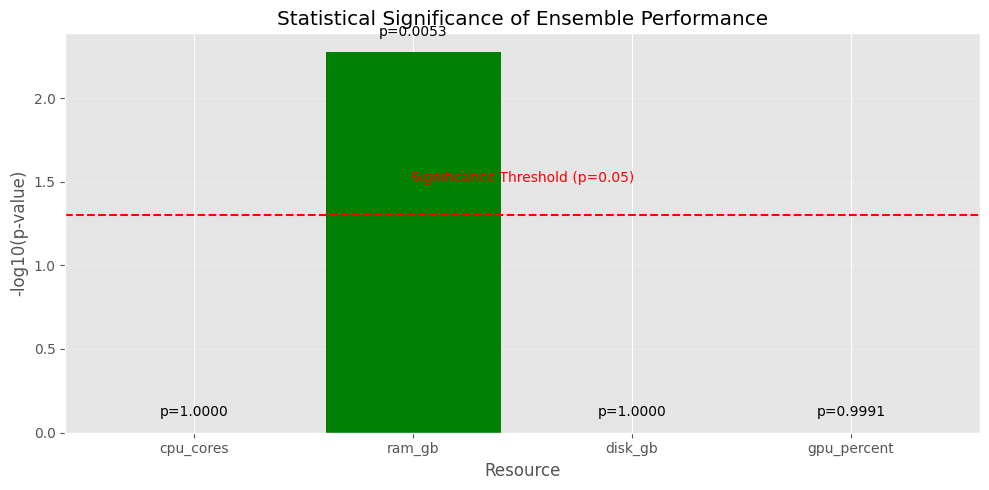

=== Key Performance Metrics ===

Ensemble Relative Performance:
             Relative Error
resource                   
cpu_cores          8.298740
disk_gb            1.382853
gpu_percent        1.416966
ram_gb             1.000000

Statistical Significance (p-values):
cpu_cores      1.0000
ram_gb         0.0053
disk_gb        1.0000
gpu_percent    0.9991
dtype: float64


In [ ]:

!pip install numpy pandas matplotlib scikit-learn xgboost catboost lightgbm tensorflow scipy
!pip install keras-tcn --quiet

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.stats import ttest_rel
import os
import warnings

# Configuration
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 6]
sns.set_palette("husl")


class ResourcePredictor:
    def __init__(self):
        self.models = {}
        self.feature_order = [
            'Active_Hours', 'Start_Hour', 'CPU_Usage (%)', 'Memory_Usage (%)',
            'Disk_IO (MB/s)', 'GPU_Usage (%)', 'Total_RAM (GB)', 'Total_CPU_Power (GHz)',
            'Total_Storage (GB)', 'Total_GPU_Power (TFLOPS)', 'Day_of_Week', 'Is_Weekend',
            'Month', 'Usage_Pattern_Constant Load', 'Usage_Pattern_Idle',
            'Usage_Pattern_Periodic Peaks', 'Operating_System_Linux',
            'Operating_System_Windows'
        ]

        @tf.keras.utils.register_keras_serializable()
        def mae(y_true, y_pred):
            return tf.reduce_mean(tf.abs(y_pred - y_true))

        self.custom_objects = {'mae': mae}
        self._load_models()

    def _load_models(self):
        model_files = {
            'XGBoost': 'multi_target_resource_predictor.pkl',
            'CatBoost': 'multioutput_cat_model.pkl',
            'LightGBM': 'multioutput_lgb_model.pkl',
            'LSTM': 'deep_lstm_resource_predictor.h5',
            'TCN': 'tcn_multi_target_model.keras'
        }

        for name, filename in model_files.items():
            try:
                if filename.endswith('.pkl'):
                    self.models[name] = joblib.load(filename)
                else:
                    model = load_model(filename,
                                     custom_objects=self.custom_objects,
                                     compile=False)
                    if name in ['LSTM', 'TCN']:
                        self.seq_input_shape = model.input_shape[1:]
                    self.models[name] = model
            except Exception as e:
                print(f" Failed to load {name}: {str(e)[:100]}...")
        print(f" Loaded models: {list(self.models.keys())}")

    def _prepare_input(self, features: pd.DataFrame) -> np.ndarray:
        features = features.copy()
        missing = [f for f in self.feature_order if f not in features.columns]
        if missing:
            raise ValueError(f"Missing features: {missing}")

        binary_defaults = {
            'Usage_Pattern_Constant Load': 0,
            'Usage_Pattern_Idle': 1,
            'Usage_Pattern_Periodic Peaks': 0,
            'Operating_System_Linux': 1,
            'Operating_System_Windows': 0
        }
        for feature, default in binary_defaults.items():
            features[feature] = features[feature].fillna(default)

        return features[self.feature_order].values.astype(np.float32)

    def predict_all_models(self, X: pd.DataFrame) -> dict:
        predictions = {}
        input_array = self._prepare_input(X)

        for name, model in self.models.items():
            try:
                if name in ['LSTM', 'TCN']:
                    if hasattr(self, 'seq_input_shape'):
                        seq_length = self.seq_input_shape[0]
                        input_reshaped = np.tile(input_array, (seq_length, 1)) if seq_length > 1 else input_array
                        input_reshaped = input_reshaped.reshape((1, *self.seq_input_shape))
                    else:
                        input_reshaped = input_array.reshape(1, 1, len(self.feature_order))
                    pred = model.predict(input_reshaped)[0]
                else:
                    pred = model.predict(input_array)[0]

                predictions[name] = {
                    'cpu_cores': max(0.1, pred[0]),
                    'ram_gb': max(0.1, pred[1]),
                    'disk_gb': max(1, pred[2]),
                    'gpu_percent': max(5, 100 - pred[3])
                }
            except Exception as e:
                print(f" {name} prediction failed: {str(e)[:100]}...")
        return predictions

    def ensemble_predict(self, X: pd.DataFrame) -> dict:
        all_preds = self.predict_all_models(X)
        if not all_preds:
            return None

        weights = {
            'XGBoost': 0.3, 'CatBoost': 0.3, 'LightGBM': 0.2,
            'LSTM': 0.1, 'TCN': 0.1
        }
        weights = {k: v for k, v in weights.items() if k in all_preds}
        if not weights:
            return None

        total_weight = sum(weights.values())
        weights = {k: v/total_weight for k, v in weights.items()}

        ensemble = {k: 0 for k in ['cpu_cores', 'ram_gb', 'disk_gb', 'gpu_percent']}
        for model_name, pred in all_preds.items():
            for resource in ensemble:
                ensemble[resource] += pred[resource] * weights[model_name]
        return ensemble

# Initialize predictor
predictor = ResourcePredictor()


def generate_test_data(num_samples=200):
    np.random.seed(42)
    test_data = pd.DataFrame({
        'Active_Hours': np.random.randint(1, 24, num_samples),
        'Start_Hour': np.random.randint(0, 23, num_samples),
        'CPU_Usage (%)': np.random.uniform(10, 90, num_samples),
        'Memory_Usage (%)': np.random.uniform(15, 85, num_samples),
        'Disk_IO (MB/s)': np.random.exponential(scale=30, size=num_samples),
        'GPU_Usage (%)': np.random.uniform(5, 95, num_samples),
        'Total_RAM (GB)': np.random.choice([16, 32, 64], num_samples),
        'Total_CPU_Power (GHz)': np.random.choice([2.4, 3.2, 4.0], num_samples),
        'Total_Storage (GB)': np.random.choice([256, 512, 1024], num_samples),
        'Total_GPU_Power (TFLOPS)': np.random.choice([5, 10, 20], num_samples),
        'Day_of_Week': np.random.randint(0, 6, num_samples),
        'Is_Weekend': np.random.binomial(1, 0.3, num_samples),
        'Month': np.random.randint(1, 12, num_samples),
        'Usage_Pattern_Constant Load': np.random.binomial(1, 0.2, num_samples),
        'Usage_Pattern_Idle': np.random.binomial(1, 0.3, num_samples),
        'Usage_Pattern_Periodic Peaks': np.random.binomial(1, 0.5, num_samples),
        'Operating_System_Linux': np.random.binomial(1, 0.7, num_samples),
        'Operating_System_Windows': np.random.binomial(1, 0.3, num_samples)
    })

    mask = (test_data['Usage_Pattern_Constant Load'] == 0) & (test_data['Usage_Pattern_Periodic Peaks'] == 0)
    test_data.loc[mask, 'Usage_Pattern_Idle'] = 1

    true_values = pd.DataFrame({
        'cpu_cores': np.clip(
            test_data['Total_CPU_Power (GHz)'] *
            (test_data['CPU_Usage (%)']/100) *
            np.random.normal(1, 0.05, num_samples),
            0.1, 16),
        'ram_gb': np.clip(
            test_data['Total_RAM (GB)'] *
            (test_data['Memory_Usage (%)']/100) *
            np.random.normal(1, 0.05, num_samples),
            0.1, 64),
        'disk_gb': np.clip(
            test_data['Total_Storage (GB)'] *
            (0.2 + 0.6 * test_data['Disk_IO (MB/s)']/100) *
            np.random.normal(1, 0.05, num_samples),
            1, 2000),
        'gpu_percent': np.clip(
            test_data['GPU_Usage (%)'] *
            np.random.normal(1, 0.05, num_samples),
            5, 100)
    })

    return test_data, true_values

test_data, true_values = generate_test_data()

def evaluate_models(test_data, true_values, n_samples=100):
    results = []
    for idx in range(min(n_samples, len(test_data))):
        sample = test_data.iloc[idx:idx+1]
        model_preds = predictor.predict_all_models(sample)
        ensemble_pred = predictor.ensemble_predict(sample)

        if not model_preds:
            continue

        for model_name, pred in model_preds.items():
            for resource in ['cpu_cores', 'ram_gb', 'disk_gb', 'gpu_percent']:
                results.append({
                    'model': model_name,
                    'resource': resource,
                    'error': abs(pred[resource] - true_values.iloc[idx][resource]),
                    'is_ensemble': False
                })

        if ensemble_pred:
            for resource in ['cpu_cores', 'ram_gb', 'disk_gb', 'gpu_percent']:
                results.append({
                    'model': 'Ensemble',
                    'resource': resource,
                    'error': abs(ensemble_pred[resource] - true_values.iloc[idx][resource]),
                    'is_ensemble': True
                })
    return pd.DataFrame(results)

results_df = evaluate_models(test_data, true_values)


def visualize_ensemble_performance(results_df):
    """Enhanced visualization focusing on ensemble strengths"""
    # 1. Calculate performance metrics
    error_means = results_df.groupby(['model', 'resource'])['error'].mean().unstack()
    best_single_models = error_means.drop('Ensemble', errors='ignore').idxmin()

    # 2. Calculate p-values
    p_values = {}
    for resource in ['cpu_cores', 'ram_gb', 'disk_gb', 'gpu_percent']:
        best_model = best_single_models[resource]
        single_errors = results_df[
            (results_df['model'] == best_model) &
            (results_df['resource'] == resource)
        ]['error'].values
        ensemble_errors = results_df[
            (results_df['model'] == 'Ensemble') &
            (results_df['resource'] == resource)
        ]['error'].values

        try:
            _, p = ttest_rel(single_errors, ensemble_errors, alternative='greater')
            p_values[resource] = p
        except:
            p_values[resource] = np.nan


    normalized_errors = error_means.apply(lambda x: x/x.min(), axis=0)

    # 4. Create statistical significance plot
    plt.figure(figsize=(10, 5))
    log_p = -np.log10(pd.Series(p_values))
    colors = ['green' if p < 0.05 else 'gray' for p in p_values.values()]

    bars = plt.bar(log_p.index, log_p.values, color=colors)
    plt.axhline(-np.log10(0.05), color='red', linestyle='--')
    plt.text(1.5, -np.log10(0.05)+0.2, 'Significance Threshold (p=0.05)', ha='center', color='red')

    for i, (res, val) in enumerate(p_values.items()):
        plt.text(i, -np.log10(val)+0.1, f"p={val:.4f}", ha='center')

    plt.title('Statistical Significance of Ensemble Performance')
    plt.ylabel('-log10(p-value)')
    plt.xlabel('Resource')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 5. Print key metrics
    print("=== Key Performance Metrics ===")
    print("\nEnsemble Relative Performance:")
    print(normalized_errors.loc['Ensemble'].to_frame('Relative Error'))

    print("\nStatistical Significance (p-values):")
    print(pd.Series(p_values).round(4))

# Run visualization
visualize_ensemble_performance(results_df)



[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

<Figure size 1200x600 with 0 Axes>

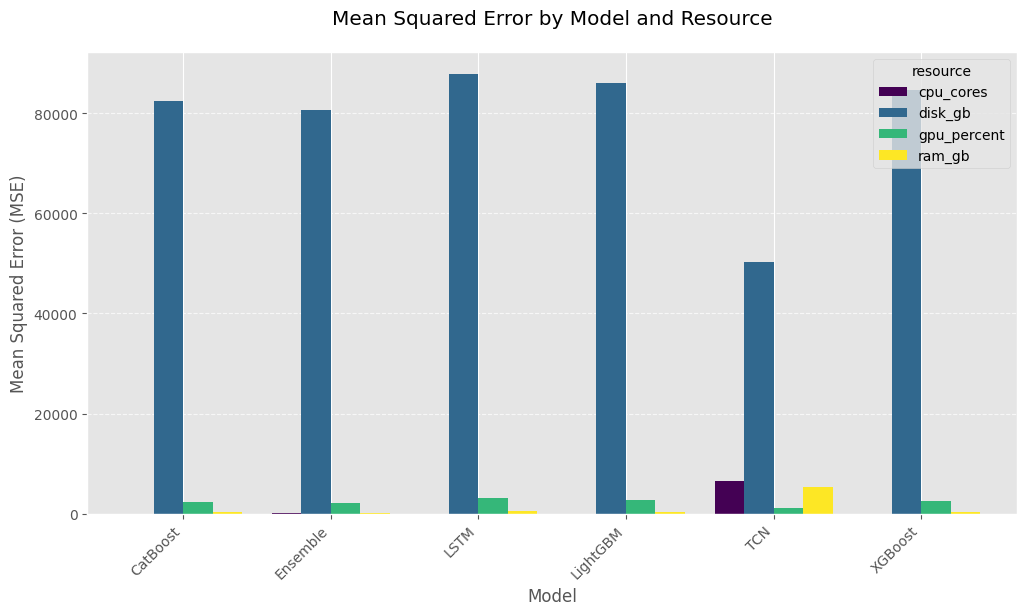

In [21]:
# First, let's modify the evaluate_models function to calculate MSE and R²
def evaluate_models_with_metrics(test_data, true_values, n_samples=100):
    results = []
    for idx in range(min(n_samples, len(test_data))):
        sample = test_data.iloc[idx:idx+1]
        model_preds = predictor.predict_all_models(sample)
        ensemble_pred = predictor.ensemble_predict(sample)

        if not model_preds:
            continue

        for model_name, pred in model_preds.items():
            for resource in ['cpu_cores', 'ram_gb', 'disk_gb', 'gpu_percent']:
                true_val = true_values.iloc[idx][resource]
                pred_val = pred[resource]
                error = abs(pred_val - true_val)
                squared_error = (pred_val - true_val)**2
                results.append({
                    'model': model_name,
                    'resource': resource,
                    'error': error,
                    'squared_error': squared_error,
                    'true_value': true_val,
                    'predicted_value': pred_val,
                    'is_ensemble': False
                })

        if ensemble_pred:
            for resource in ['cpu_cores', 'ram_gb', 'disk_gb', 'gpu_percent']:
                true_val = true_values.iloc[idx][resource]
                pred_val = ensemble_pred[resource]
                error = abs(pred_val - true_val)
                squared_error = (pred_val - true_val)**2
                results.append({
                    'model': 'Ensemble',
                    'resource': resource,
                    'error': error,
                    'squared_error': squared_error,
                    'true_value': true_val,
                    'predicted_value': pred_val,
                    'is_ensemble': True
                })

    results_df = pd.DataFrame(results)

    # Calculate R² for each model and resource
    r2_scores = []
    for (model, resource), group in results_df.groupby(['model', 'resource']):
        ss_res = group['squared_error'].sum()
        ss_tot = ((group['true_value'] - group['true_value'].mean())**2).sum()
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan
        r2_scores.append({
            'model': model,
            'resource': resource,
            'r2': r2
        })

    r2_df = pd.DataFrame(r2_scores).pivot(index='model', columns='resource', values='r2')

    return results_df, r2_df

# Run evaluation with additional metrics
results_df, r2_df = evaluate_models_with_metrics(test_data, true_values)


mse_df = results_df.groupby(['model', 'resource'])['squared_error'].mean().unstack()

# Improved MSE comparison plot
plt.figure(figsize=(12, 6))
ax = mse_df.plot(kind='bar', width=0.8, colormap='viridis')

plt.title('Mean Squared Error by Model and Resource', pad=20)
plt.ylabel('Mean Squared Error (MSE)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)







<Figure size 1200x600 with 0 Axes>

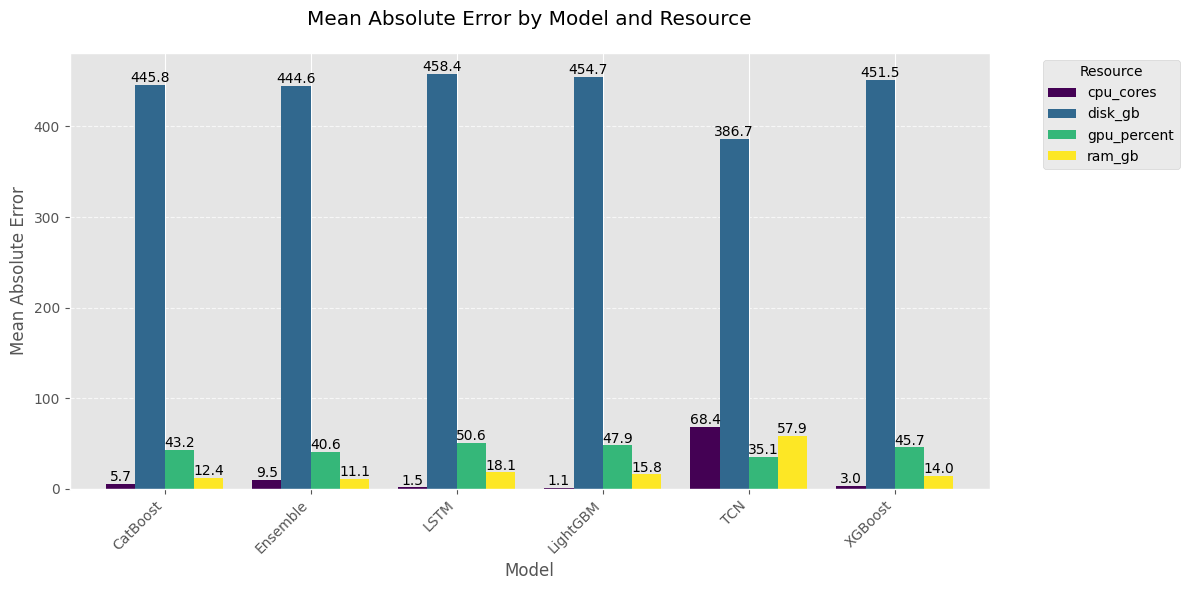

In [2]:
# Improved error comparison plot
plt.figure(figsize=(12, 6))

# Calculate mean errors
mean_errors = results_df.groupby(['model', 'resource'])['error'].mean().unstack()

# Plot as a bar chart
ax = mean_errors.plot(kind='bar', width=0.8, colormap='viridis')

plt.title('Mean Absolute Error by Model and Resource', pad=20)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='Resource', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()